In [1]:
import pandas as pd
import numpy as np
from Fingerprint.Hash2BitManager       import Hash2Bits, FindBitLength, GenerateFpsArray
from Kernels.Kernel          import funcTanimotoKernel_MMPKernel, funcTanimotoSklearn
from functools import partial
from Similarity.SimilarityHist import flattenTC
import seaborn as sns
import os
from scipy.special import rel_entr

def assign_vals(table, cols, new_col):
    for i, c in enumerate(cols):
        new_c = new_col[i]
        table[new_c] = 0
        for tid in table.index:
            data = pd.read_csv('./Dataset/Data/%s.tsv'%tid, sep='\t', index_col=0)
            table.loc[tid, new_c] = data[c].max()

    return table

def MakeSimilarityHistogram(target, use_zero=True, core_only=True, del_zero=True):
    df_tlist = pd.read_csv('./Dataset/target_list.tsv', sep='\t', index_col='chembl_tid') 
    df_main = pd.read_csv('./Dataset/Data/%s.tsv'%target, sep='\t', index_col=0)
    df_ecfp = pd.read_csv('./Dataset/ECFP/%s.tsv'%target, sep='\t', index_col=0)

    len_c = FindBitLength(df_ecfp, ['core'])
    len_s = FindBitLength(df_ecfp, ['sub1', 'sub2', 'overlap'])

    mms = df_ecfp.loc[df_main.drop_duplicates(['core_id']).index,:]

    fpgen = Hash2Bits()
    
    if not core_only:
        fp = GenerateFpsArray(mms['core'], nbits=len_c) 
        mat = funcTanimotoSklearn(fp, fp)
        sim = flattenTC(mat)
        #sim = np.max(mat, axis=1).reshape(-1)
        
    else:
        fp = fpgen.GetMMPfingerprints_DF_unfold(df_ecfp, ['core', 'sub1', 'sub2', 'overlap'], nbits=[len_c, len_s], overlap='concat')
        simfunc = partial(funcTanimotoKernel_MMPKernel, len_c=len_c)
        mat = simfunc(fp,fp)
        sim = flattenTC(mat)
        #sim = np.max(mat, axis=1).reshape(-1)
    
    sim = np.array(sim)
    
    if del_zero:
        sim  = sim[np.where(sim>0)[0]]
        bins = [0.00000001] + [0.1*i for i in range(1, 10)]
    
    else:
        bins = [0.1*i for i in range(10)]
        
    hist = np.histogram(sim, bins=bins, density=True)
    return hist

def kl_divergence(p, q):
	return sum(rel_entr(p,q))

def js_divergence(p, q):
    
    m = 0.5 * (p + q)
    
    return 0.5 * kl_divergence(p, m) + 0.5 * kl_divergence(q, m)


def histogram_intersection(p, q):
    return sum([min(p_bin, q_bin) for p_bin, q_bin in zip(p, q)])

from itertools import product

def pairwise_calculation(func, labels, values):
    vals = np.array([func(i,j) for i, j in product(values, values)]).reshape(len(labels),-1)
    return pd.DataFrame(vals, index=labels, columns=labels)

# Cpdout

In [2]:
type = 'cpdout'

svm     = pd.read_csv('./Score_axv/SVM/mean_%s.tsv'%type, sep='\t', index_col=0)
xgb     = pd.read_csv('./Score_axv/XGBoost/mean_%s.tsv'%type, sep='\t', index_col=0)
rf      = pd.read_csv('./Score_axv/Random_Forest/mean_%s.tsv'%type, sep='\t', index_col=0)
fcn     = pd.read_csv('./Score_axv/FCNN/mean_%s.tsv'%type, sep='\t', index_col=0)
fcn_sep = pd.read_csv('./Score_axv/FCNN_separated/mean_%s.tsv'%type, sep='\t', index_col=0)
#mpn     = pd.read_csv('./Score_axv/MPNN/mean_%s.tsv'%type, sep='\t', index_col=0)
#mpn_sep = pd.read_csv('./Score_axv/MPNN_separated/mean_%s.tsv'%type, sep='\t', index_col=0)
nn1     = pd.read_csv('./Score_axv/1NN/mean_%s.tsv'%type, sep='\t', index_col=0)
nn5     = pd.read_csv('./Score_axv/5NN/mean_%s.tsv'%type, sep='\t', index_col=0)


svm     = assign_vals(svm, cols=['thres', 'core_id'], new_col=['thres', '#MMS'])
xgb     = assign_vals(xgb, cols=['thres', 'core_id'], new_col=['thres', '#MMS'])
rf      = assign_vals(rf , cols=['thres', 'core_id'], new_col=['thres', '#MMS'])
fcn     = assign_vals(fcn, cols=['thres', 'core_id'], new_col=['thres', '#MMS'])
fcn_sep = assign_vals(fcn_sep, cols=['thres', 'core_id'], new_col=['thres', '#MMS'])
#mpn     = assign_vals(mpn, cols=['thres', 'core_id'], new_col=['thres', '#MMS'])
#mpn_sep = assign_vals(mpn_sep, cols=['thres', 'core_id'], new_col=['thres', '#MMS'])
nn1     = assign_vals(nn1, cols=['thres', 'core_id'], new_col=['thres', '#MMS'])
nn5     = assign_vals(nn5, cols=['thres', 'core_id'], new_col=['thres', '#MMS'])


svm['model']     = 'svm'
xgb['model']     = 'xgb'
rf['model']      = 'rf'
fcn['model']     = 'fcnn'
fcn_sep['model'] = 'fcnn_sep'
#mpn['model']     = 'mpnn'
#mpn_sep['model'] = 'mpnn_sep'
nn1['model']     = '1NN'
nn5['model']     = '5NN'


#all_score = pd.concat([svm, xgb, rf, fcn, fcn_sep, mpn, mpn_sep, nn1, nn5])
all_score = pd.concat([svm, xgb, rf, fcn, fcn_sep, nn1, nn5])

In [3]:
from collections import defaultdict

tnames = defaultdict(list)
scores = defaultdict(list)

#for name, ml in zip(['svm', 'rf', 'fcn_sep', 'mpn_sep'], [svm, rf, fcn_sep, mpn_sep]):
for name, ml in zip(['svm', 'rf', 'fcn_sep'], [svm, rf, fcn_sep]):
    tnames[name] = list(ml.sort_values('matthews_coeff', ascending=False).index[:40])
    scores[name] = list(ml.sort_values('matthews_coeff', ascending=False)['matthews_coeff'].iloc[:40])
    
tnames = pd.DataFrame.from_dict(tnames, orient='columns')
scores = pd.DataFrame.from_dict(scores, orient='columns')

In [4]:
tnames

,svm,rf,fcn_sep
0,CHEMBL1800,CHEMBL1800,CHEMBL3729
1,CHEMBL4523,CHEMBL4523,CHEMBL1800
2,CHEMBL204,CHEMBL335,CHEMBL204
3,CHEMBL244,CHEMBL204,CHEMBL4523
4,CHEMBL2820,CHEMBL244,CHEMBL244
5,CHEMBL2147,CHEMBL3837,CHEMBL237
6,CHEMBL335,CHEMBL4072,CHEMBL4072
7,CHEMBL3837,CHEMBL2147,CHEMBL3837
8,CHEMBL4072,CHEMBL3594,CHEMBL335
9,CHEMBL236,CHEMBL234,CHEMBL236


In [5]:
scores

,svm,rf,fcn_sep
0,0.861,0.914,0.767
1,0.830,0.830,0.766
2,0.779,0.698,0.755
3,0.686,0.693,0.752
4,0.641,0.670,0.647
5,0.556,0.627,0.613
6,0.553,0.607,0.610
7,0.517,0.584,0.608
8,0.508,0.507,0.556
9,0.492,0.506,0.526


In [6]:
df = tnames.iloc[:10,:]
stats = pd.DataFrame(pd.Series(df.values.reshape(-1)).value_counts())
stats['ml'] = ''

for target in stats.index:
    for ml in df.columns:
        if any(target == df[ml]):
            obj = stats.loc[target,'ml']
            stats.loc[target,'ml'] = obj + '  ' + ml
            
stats['bool'] = [True if i in ['  fcn_sep', '  mpn_sep'] else False for i in stats['ml']]

flags = []

for target, series in stats.iterrows():
    
    b = series['bool']
    
    if not b:
        flags += [True]
        continue
    
    metric = stats.loc[target, 'ml'][2:] 
    
    metric_idx = np.where(df[metric]==target)[0]
    svm_idx = np.where(tnames['svm']==target)[0]
    rf_idx  = np.where(tnames['rf']==target)[0]
    
    
    metric_score = scores.loc[metric_idx[0], metric]
    
    if svm_idx.shape[0]>0:
        svm_score = scores.loc[svm_idx[0], 'svm']
    else:
        svm_score = 0
        
    if rf_idx.shape[0]>0:
        rf_score  = scores.loc[rf_idx[0] , 'rf']
    else:
        rf_score = 0
    
    print(metric_score, svm_score, rf_score)
    flag = bool( (metric_score > svm_score) * (metric_score > rf_score) )
    
    flags += [flag]
    
stats['flag'] = flags
    
    

0.767 0.39 0.273
0.613 0.48200000000000004 0.384


In [7]:
stats = stats.loc[stats['flag'], :]
stats

,0,ml,bool,flag
CHEMBL3837,3,svm rf fcn_sep,False,True
CHEMBL4072,3,svm rf fcn_sep,False,True
CHEMBL244,3,svm rf fcn_sep,False,True
CHEMBL335,3,svm rf fcn_sep,False,True
CHEMBL1800,3,svm rf fcn_sep,False,True
CHEMBL4523,3,svm rf fcn_sep,False,True
CHEMBL204,3,svm rf fcn_sep,False,True
CHEMBL2147,2,svm rf,False,True
CHEMBL236,2,svm fcn_sep,False,True
CHEMBL3729,1,fcn_sep,True,True


In [9]:
dict_hist      = {t:MakeSimilarityHistogram(target=t, core_only=False)[0] for t in stats.index}
dict_hist_core = {t:MakeSimilarityHistogram(target=t, core_only=True)[0] for t in stats.index}

/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x:[int(h) for h in x.split(" ")] if isinstance(x, str) else [-1])
/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x:[int(h) for h in x.split(" ")] if isinstance(x, str) else [-1])
/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: Sett

    $ Overlap option is selected as concat


/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x:[int(h) for h in x.split(" ")] if isinstance(x, str) else [-1])


    $ Overlap option is selected as concat


/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x:[int(h) for h in x.split(" ")] if isinstance(x, str) else [-1])


    $ Overlap option is selected as concat


/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x:[int(h) for h in x.split(" ")] if isinstance(x, str) else [-1])
/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x:[int(h) for h in x.split(" ")] if isinstance(x, str) else [-1])


    $ Overlap option is selected as concat
    $ Overlap option is selected as concat


/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x:[int(h) for h in x.split(" ")] if isinstance(x, str) else [-1])


    $ Overlap option is selected as concat


/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x:[int(h) for h in x.split(" ")] if isinstance(x, str) else [-1])


    $ Overlap option is selected as concat


/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x:[int(h) for h in x.split(" ")] if isinstance(x, str) else [-1])


    $ Overlap option is selected as concat


/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x:[int(h) for h in x.split(" ")] if isinstance(x, str) else [-1])


    $ Overlap option is selected as concat


/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x:[int(h) for h in x.split(" ")] if isinstance(x, str) else [-1])


    $ Overlap option is selected as concat


/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x:[int(h) for h in x.split(" ")] if isinstance(x, str) else [-1])


    $ Overlap option is selected as concat


/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x:[int(h) for h in x.split(" ")] if isinstance(x, str) else [-1])


    $ Overlap option is selected as concat


/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x:[int(h) for h in x.split(" ")] if isinstance(x, str) else [-1])


    $ Overlap option is selected as concat


/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x:[int(h) for h in x.split(" ")] if isinstance(x, str) else [-1])


    $ Overlap option is selected as concat


In [10]:
stats.index

Index(['CHEMBL3837', 'CHEMBL4072', 'CHEMBL244', 'CHEMBL335', 'CHEMBL1800',
       'CHEMBL4523', 'CHEMBL204', 'CHEMBL2147', 'CHEMBL236', 'CHEMBL3729',
       'CHEMBL234', 'CHEMBL237', 'CHEMBL2820', 'CHEMBL3594'],
      dtype='object')

# Compare histogram

In [11]:
classic = [2147, 234, 2820, 3594] #[1800, 3991, 3018, 1741186, 1926488, 3729, 2820, 1795117, 5113]
nn_both = [] #[244, 237]
nn_fcn  = [3729, 237] #[214, 5023]
nn_mpn  = [] #[251, 236, 344]
allml   = [3837, 4072, 244, 335, 1800, 4523, 204, 236] #[204, 5407, 2954, 333, 4523, 4072, 2147, 335, 255]

col = ['CHEMBL%d'%i for i in classic+nn_both+nn_fcn+nn_mpn+allml]

## js_divergence

In [12]:
js   = pairwise_calculation(js_divergence, col, [dict_hist[c] for c in col])
js_c = pairwise_calculation(js_divergence, col, [dict_hist_core[c] for c in col])
js

,CHEMBL2147,CHEMBL234,CHEMBL2820,CHEMBL3594,CHEMBL3729,CHEMBL237,CHEMBL3837,CHEMBL4072,CHEMBL244,CHEMBL335,CHEMBL1800,CHEMBL4523,CHEMBL204,CHEMBL236
CHEMBL2147,0.000000,0.530178,0.227115,0.548092,0.731953,0.100219,0.225372,0.118264,0.312530,0.251081,0.253407,0.005931,0.349565,0.145958
CHEMBL234,0.530178,0.000000,0.309096,0.194175,0.089450,0.419222,0.181257,0.237063,0.493324,0.723192,0.576246,0.508186,0.422909,0.563948
CHEMBL2820,0.227115,0.309096,0.000000,0.628998,0.443005,0.386234,0.330982,0.173350,0.696355,0.220373,0.216643,0.183743,0.681553,0.541000
CHEMBL3594,0.548092,0.194175,0.628998,0.000000,0.265331,0.307118,0.100000,0.263250,0.164968,0.919858,0.870321,0.553824,0.111659,0.346940
CHEMBL3729,0.731953,0.089450,0.443005,0.265331,0.000000,0.534788,0.281470,0.387624,0.650488,0.732586,0.681892,0.686728,0.568976,0.694340
CHEMBL237,0.100219,0.419222,0.386234,0.307118,0.534788,0.000000,0.090040,0.102131,0.120974,0.377556,0.375469,0.117931,0.142764,0.021608
CHEMBL3837,0.225372,0.181257,0.330982,0.100000,0.281470,0.090040,0.000000,0.053451,0.106845,0.515171,0.509150,0.230140,0.087951,0.139752
CHEMBL4072,0.118264,0.237063,0.173350,0.263250,0.387624,0.102131,0.053451,0.000000,0.214861,0.327924,0.353792,0.119133,0.207441,0.169113
CHEMBL244,0.312530,0.493324,0.696355,0.164968,0.650488,0.120974,0.106845,0.214861,0.000000,0.807204,0.805993,0.350302,0.007563,0.086200
CHEMBL335,0.251081,0.723192,0.220373,0.919858,0.732586,0.377556,0.515171,0.327924,0.807204,0.000000,0.198570,0.210693,0.834001,0.483654


In [13]:
os.makedirs('./Score_axv/similarity_hist', exist_ok=True)
js.to_csv('./Score_axv/similarity_hist/%s_js_div.tsv'%type, sep='\t')
js_c.to_csv('./Score_axv/similarity_hist/%s_js_div_core.tsv'%type, sep='\t')

## histogram intersection

In [14]:
hi   = pairwise_calculation(histogram_intersection, col, [dict_hist[c] for c in col])
hi_c = pairwise_calculation(histogram_intersection, col, [dict_hist_core[c] for c in col])
hi

,CHEMBL2147,CHEMBL234,CHEMBL2820,CHEMBL3594,CHEMBL3729,CHEMBL237,CHEMBL3837,CHEMBL4072,CHEMBL244,CHEMBL335,CHEMBL1800,CHEMBL4523,CHEMBL204,CHEMBL236
CHEMBL2147,10.000001,7.416498,8.152267,8.239314,6.781745,9.054879,8.755044,9.154262,8.405032,8.006195,8.112714,9.707231,8.387700,8.805321
CHEMBL234,7.416498,10.000000,8.512705,8.379515,8.904315,7.599046,8.261190,8.084423,7.126100,7.694899,7.762623,7.555035,7.283815,7.184891
CHEMBL2820,8.152267,8.512705,10.000000,7.657127,8.157316,7.721246,8.040828,8.360044,6.774066,9.095929,8.766046,8.351744,6.931303,7.207924
CHEMBL3594,8.239314,8.379515,7.657127,10.000001,7.879608,8.700403,9.479686,8.961257,8.537753,7.265690,7.188309,8.160800,8.761329,8.381704
CHEMBL3729,6.781745,8.904315,8.157316,7.879608,10.000000,7.035226,7.709797,7.539364,6.578853,7.498716,7.495332,6.955086,6.772183,6.688166
CHEMBL237,9.054879,7.599046,7.721246,8.700403,7.035226,10.000001,9.200522,9.128975,8.976859,7.685749,7.727457,8.979730,9.041422,9.486678
CHEMBL3837,8.755044,8.261190,8.040828,9.479686,7.709797,9.200522,10.000001,9.382048,8.733239,7.759389,7.676830,8.677207,8.890476,8.845350
CHEMBL4072,9.154262,8.084423,8.360044,8.961257,7.539364,9.128975,9.382048,10.000001,8.411521,7.981582,8.082883,9.190785,8.568758,8.760177
CHEMBL244,8.405032,7.126100,6.774066,8.537753,6.578853,8.976859,8.733239,8.411521,10.000001,6.752526,6.780277,8.289930,9.772258,9.395400
CHEMBL335,8.006195,7.694899,9.095929,7.265690,7.498716,7.685749,7.759389,7.981582,6.752526,10.000000,8.916667,8.210854,6.817089,7.285564


In [15]:
hi.to_csv('./Score_axv/similarity_hist/%s_hi_sim.tsv'%type, sep='\t')
hi_c.to_csv('./Score_axv/similarity_hist/%s_hi_sim_core.tsv'%type, sep='\t')

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

def heatmap(df, outpath=None, cmap_rev=True):
    # Create a mask
    mask = None

    #Create a matplotlib colormap from the sns seagreen color palette
    cmap = sns.light_palette("blue", reverse=cmap_rev, as_cmap=True )
    # Normalize to the range of possible values from df["c"]
    norm = matplotlib.colors.Normalize(vmin=df.min().min(), vmax=df.max().max())
    # create a color dictionary (value in c : color from colormap) 
    colors = {}
    for cval in df.values.reshape(-1):
        colors.update({cval : cmap(norm(cval))})
        
    fig, ax = plt.subplots(figsize=(15,15))
    sns.heatmap(df, mask=mask, center=0, annot=True,
                fmt='.2f', square=True, cmap=cmap)

    if outpath==None:
        plt.show()
    else:
        plt.savefig(outpath)
        
    return ax

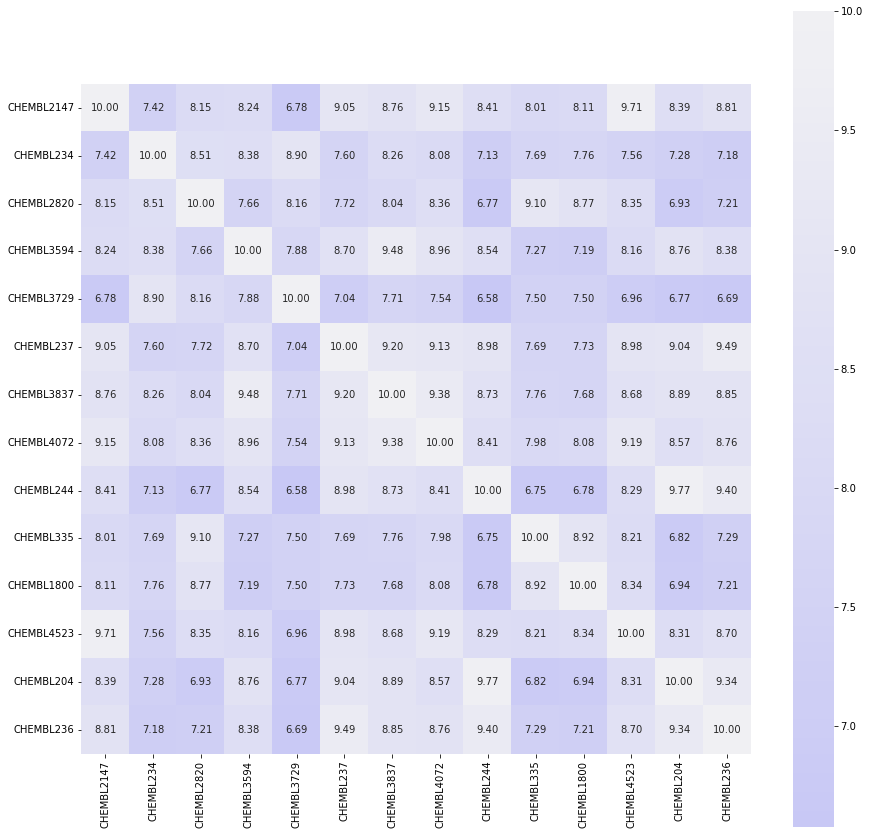

In [17]:
ax = heatmap(hi, outpath='./Score_axv/similarity_hist/heatmap_%s_hi.svg'%type)

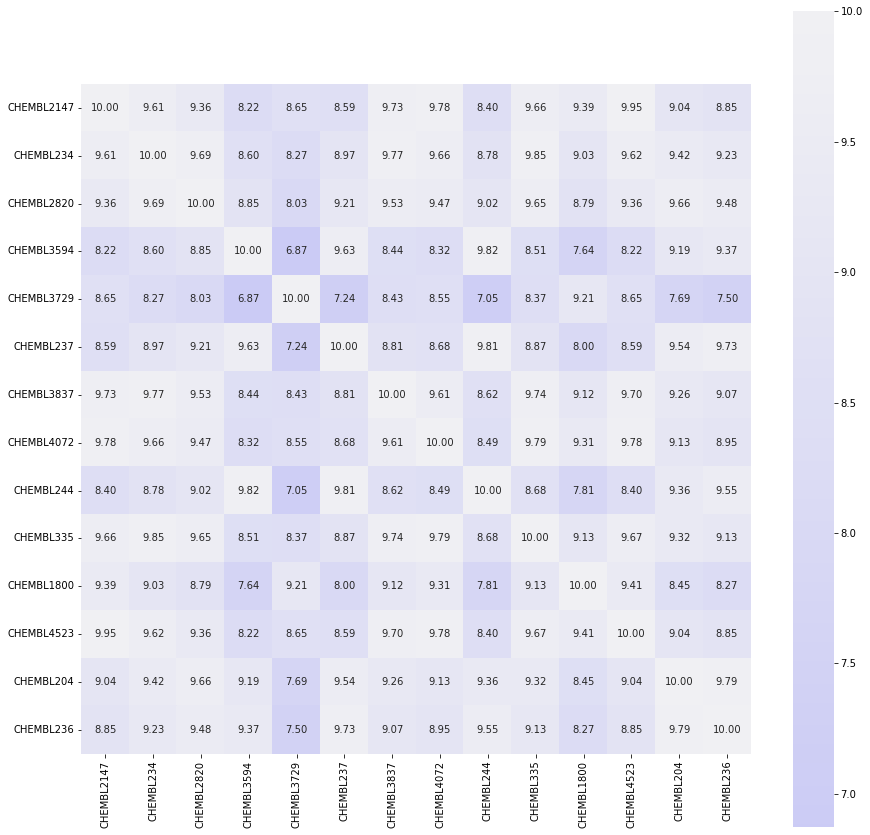

In [18]:
ax = heatmap(hi_c, outpath='./Score_axv/similarity_hist/heatmap_%s_hi_core.svg'%type)

In [19]:
def regional_average(val, r_from, r_to, c_from, c_to):
    
    val_sub = val[r_from:r_to, c_from:c_to]
    
    if r_from==c_from:
        ave = (val_sub.sum().sum() - np.diag(val_sub).sum()) / (val_sub.shape[0]*val_sub.shape[1]-np.diag(val_sub).shape[0])
    else:
        ave = val_sub.sum().sum() / (val_sub.shape[0]*val_sub.shape[1])
    return ave


def regional_median(val, r_from, r_to, c_from, c_to):
    
    val_sub = val[r_from:r_to, c_from:c_to]
    
    if r_from==c_from:
        triu = np.triu(val_sub,1).reshape(-1)
        med  = np.median(triu[np.where(triu>0)[0]])
    else:
        med  = np.median(val_sub.reshape(-1)) 
    return med
    

In [20]:
val = hi.values
idx = [0, 5, 7]

for i in range(1, len(idx)):
    for j in range(1, len(idx)):
        ave = regional_average(val, idx[i-1], idx[i], idx[j-1], idx[j])
        print(round(ave, 2))

8.01
8.24
8.24
9.2


In [21]:
for i in range(1, len(idx)):
    for j in range(1, len(idx)):
        med = regional_median(val, idx[i-1], idx[i], idx[j-1], idx[j])
        print(round(med, 2))

8.15
8.15
8.15
9.2


In [22]:
val = hi_c.values
for i in range(1, len(idx)):
    for j in range(1, len(idx)):
        ave = regional_average(val, idx[i-1], idx[i], idx[j-1], idx[j])
        print(round(ave, 2))

8.62
8.95
8.95
8.81


In [23]:
for i in range(1, len(idx)):
    for j in range(1, len(idx)):
        med = regional_median(val, idx[i-1], idx[i], idx[j-1], idx[j])
        print(round(med, 2))

8.63
9.09
9.09
8.81


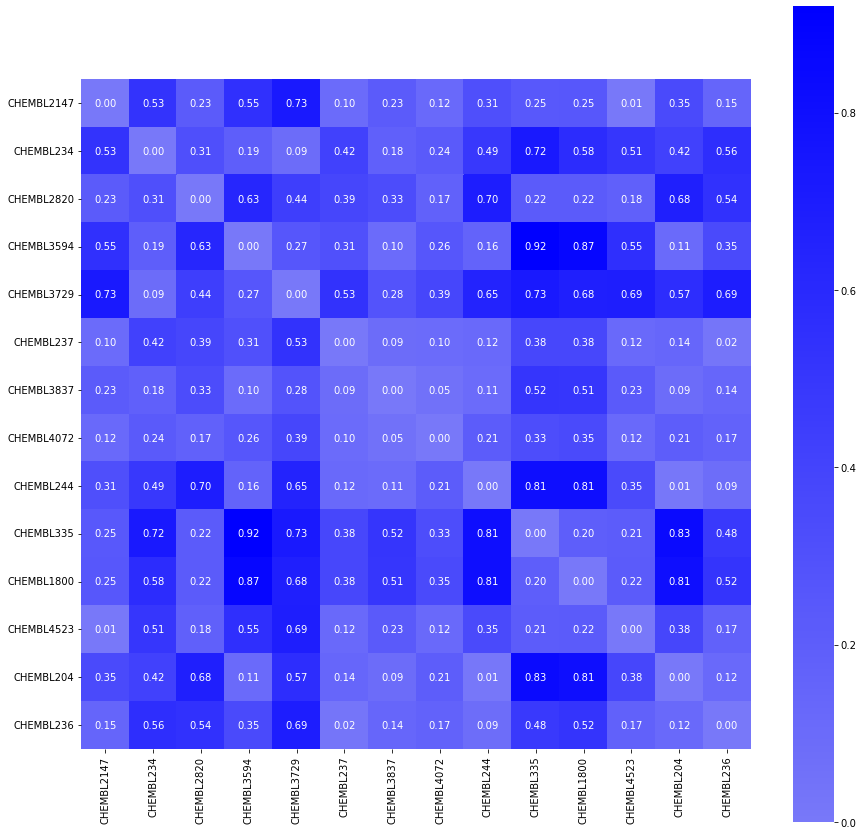

In [24]:
ax = heatmap(js, outpath='Score_axv/similarity_hist/heatmap_%s_js.svg'%type, cmap_rev=False)

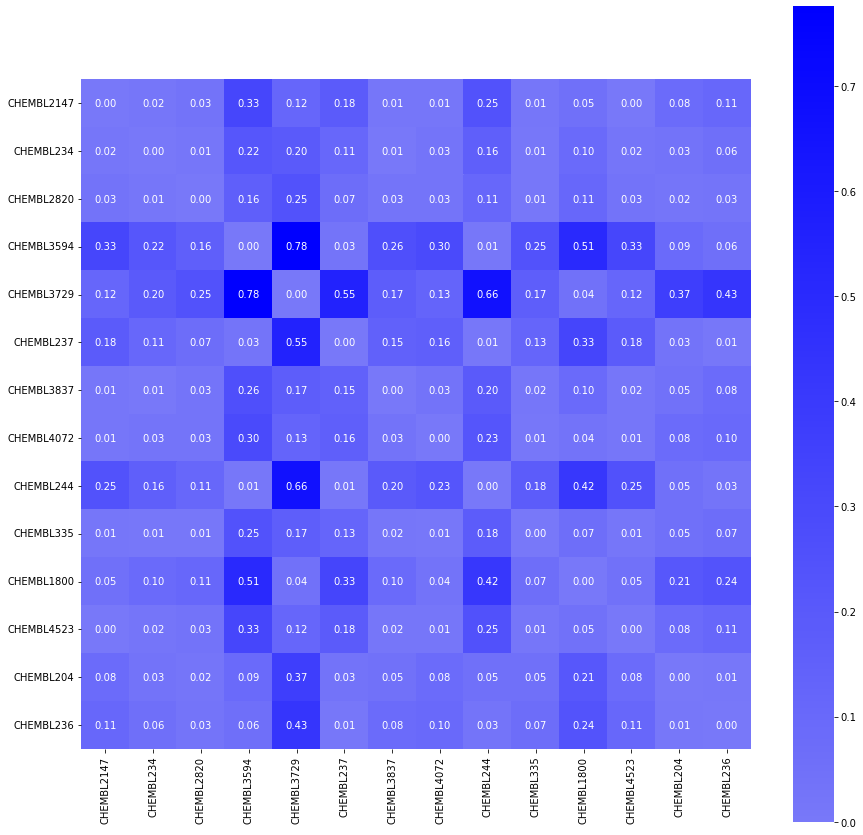

In [25]:
ax = heatmap(js_c, outpath='Score_axv/similarity_hist/heatmap_%s_js_core.svg'%type, cmap_rev=False)

In [26]:
val = js.values

for i in range(1, len(idx)):
    for j in range(1, len(idx)):
        ave = regional_average(val, idx[i-1], idx[i], idx[j-1], idx[j])
        print(round(ave, 2))

0.4
0.29
0.29
0.09


In [27]:
for i in range(1, len(idx)):
    for j in range(1, len(idx)):
        med = regional_median(val, idx[i-1], idx[i], idx[j-1], idx[j])
        print(round(med, 2))

0.38
0.29
0.29
0.09


In [28]:
val = js_c.values

for i in range(1, len(idx)):
    for j in range(1, len(idx)):
        ave = regional_average(val, idx[i-1], idx[i], idx[j-1], idx[j])
        print(round(ave, 2))

0.21
0.14
0.14
0.15


In [29]:
for i in range(1, len(idx)):
    for j in range(1, len(idx)):
        med = regional_median(val, idx[i-1], idx[i], idx[j-1], idx[j])
        print(round(med, 2))

0.18
0.09
0.09
0.15


# Target name

In [30]:
tlist = pd.read_csv('./Dataset/target_list.tsv', sep='\t', index_col='chembl_tid')

for tid in hi.keys():
    print(tid, ': ', tlist.loc[tid, 'primary_name'])

CHEMBL2147 :  Serine/threonine-protein kinase pim-1
CHEMBL234 :  D(3) dopamine receptor
CHEMBL2820 :  Coagulation factor XI
CHEMBL3594 :  Carbonic anhydrase 9
CHEMBL3729 :  Carbonic anhydrase 4
CHEMBL237 :  Kappa-type opioid receptor
CHEMBL3837 :  Procathepsin L
CHEMBL4072 :  Cathepsin B
CHEMBL244 :  Coagulation factor X
CHEMBL335 :  Tyrosine-protein phosphatase non-receptor type 1
CHEMBL1800 :  Corticotropin-releasing factor receptor 1
CHEMBL4523 :  Serine/threonine-protein kinase pim-2
CHEMBL204 :  Prothrombin
CHEMBL236 :  Delta-type opioid receptor


# Bothout

In [32]:
type = 'bothout'

svm     = pd.read_csv('./Score_axv/SVM/mean_%s.tsv'%type, sep='\t', index_col=0)
xgb     = pd.read_csv('./Score_axv/XGBoost/mean_%s.tsv'%type, sep='\t', index_col=0)
rf      = pd.read_csv('./Score_axv/Random_Forest/mean_%s.tsv'%type, sep='\t', index_col=0)
fcn     = pd.read_csv('./Score_axv/FCNN/mean_%s.tsv'%type, sep='\t', index_col=0)
fcn_sep = pd.read_csv('./Score_axv/FCNN_separated/mean_%s.tsv'%type, sep='\t', index_col=0)
#mpn     = pd.read_csv('./Score_axv/MPNN/mean_%s.tsv'%type, sep='\t', index_col=0)
#mpn_sep = pd.read_csv('./Score_axv/MPNN_separated/mean_%s.tsv'%type, sep='\t', index_col=0)
nn1     = pd.read_csv('./Score_axv/1NN/mean_%s.tsv'%type, sep='\t', index_col=0)
nn5     = pd.read_csv('./Score_axv/5NN/mean_%s.tsv'%type, sep='\t', index_col=0)


svm     = assign_vals(svm, cols=['thres', 'core_id'], new_col=['thres', '#MMS'])
xgb     = assign_vals(xgb, cols=['thres', 'core_id'], new_col=['thres', '#MMS'])
rf      = assign_vals(rf , cols=['thres', 'core_id'], new_col=['thres', '#MMS'])
fcn     = assign_vals(fcn, cols=['thres', 'core_id'], new_col=['thres', '#MMS'])
fcn_sep = assign_vals(fcn_sep, cols=['thres', 'core_id'], new_col=['thres', '#MMS'])
#mpn     = assign_vals(mpn, cols=['thres', 'core_id'], new_col=['thres', '#MMS'])
#mpn_sep = assign_vals(mpn_sep, cols=['thres', 'core_id'], new_col=['thres', '#MMS'])
nn1     = assign_vals(nn1, cols=['thres', 'core_id'], new_col=['thres', '#MMS'])
nn5     = assign_vals(nn5, cols=['thres', 'core_id'], new_col=['thres', '#MMS'])


svm['model']     = 'svm'
xgb['model']     = 'xgb'
rf['model']      = 'rf'
fcn['model']     = 'fcnn'
fcn_sep['model'] = 'fcnn_sep'
#mpn['model']     = 'mpnn'
#mpn_sep['model'] = 'mpnn_sep'
nn1['model']     = '1NN'
nn5['model']     = '5NN'


#all_score = pd.concat([svm, xgb, rf, fcn, fcn_sep, mpn, mpn_sep, nn1, nn5])
all_score = pd.concat([svm, xgb, rf, fcn, fcn_sep, nn1, nn5])

In [34]:
from collections import defaultdict

tnames = defaultdict(list)
scores = defaultdict(list)

#for name, ml in zip(['svm', 'rf', 'fcn_sep', 'mpn_sep'], [svm, rf, fcn_sep, mpn_sep]):
for name, ml in zip(['svm', 'rf', 'fcn_sep'], [svm, rf, fcn_sep]):
    tnames[name] = list(ml.sort_values('matthews_coeff', ascending=False).index[:40])
    scores[name] = list(ml.sort_values('matthews_coeff', ascending=False)['matthews_coeff'].iloc[:40])
    
tnames = pd.DataFrame.from_dict(tnames, orient='columns')
scores = pd.DataFrame.from_dict(scores, orient='columns')

In [35]:
tnames

,svm,rf,fcn_sep
0,CHEMBL1800,CHEMBL1800,CHEMBL4523
1,CHEMBL4523,CHEMBL4523,CHEMBL1800
2,CHEMBL244,CHEMBL3837,CHEMBL3837
3,CHEMBL2820,CHEMBL205,CHEMBL244
4,CHEMBL205,CHEMBL218,CHEMBL205
5,CHEMBL236,CHEMBL244,CHEMBL237
6,CHEMBL2034,CHEMBL253,CHEMBL2147
7,CHEMBL2147,CHEMBL261,CHEMBL344
8,CHEMBL204,CHEMBL4072,CHEMBL218
9,CHEMBL3242,CHEMBL233,CHEMBL264


In [36]:
scores

,svm,rf,fcn_sep
0,0.779,0.779,0.681
1,0.681,0.681,0.627
2,0.511,0.560,0.557
3,0.484,0.455,0.498
4,0.480,0.363,0.473
5,0.382,0.324,0.456
6,0.368,0.297,0.438
7,0.367,0.278,0.390
8,0.363,0.252,0.385
9,0.334,0.220,0.365


In [37]:
df = tnames.iloc[:10,:]
stats = pd.DataFrame(pd.Series(df.values.reshape(-1)).value_counts())
stats['ml'] = ''

for target in stats.index:
    for ml in df.columns:
        if any(target == df[ml]):
            obj = stats.loc[target,'ml']
            stats.loc[target,'ml'] = obj + '  ' + ml
            
stats['bool'] = [True if i in ['  fcn_sep', '  mpn_sep'] else False for i in stats['ml']]

flags = []

for target, series in stats.iterrows():
    
    b = series['bool']
    
    if not b:
        flags += [True]
        continue
    
    metric = stats.loc[target, 'ml'][2:] 
    
    metric_idx = np.where(df[metric]==target)[0]
    svm_idx = np.where(tnames['svm']==target)[0]
    rf_idx  = np.where(tnames['rf']==target)[0]
    
    
    metric_score = scores.loc[metric_idx[0], metric]
    
    if svm_idx.shape[0]>0:
        svm_score = scores.loc[svm_idx[0], 'svm']
    else:
        svm_score = 0
        
    if rf_idx.shape[0]>0:
        rf_score  = scores.loc[rf_idx[0] , 'rf']
    else:
        rf_score = 0
    
    print(metric_score, svm_score, rf_score)
    flag = bool( (metric_score > svm_score) * (metric_score > rf_score) )
    
    flags += [flag]
    
stats['flag'] = flags
    
    

0.39 0.161 0.1
0.456 0.316 0.0
0.365 0.205 0.053


In [38]:
stats = stats.loc[stats['flag'], :]
stats

,0,ml,bool,flag
CHEMBL4523,3,svm rf fcn_sep,False,True
CHEMBL205,3,svm rf fcn_sep,False,True
CHEMBL244,3,svm rf fcn_sep,False,True
CHEMBL1800,3,svm rf fcn_sep,False,True
CHEMBL3837,2,rf fcn_sep,False,True
CHEMBL218,2,rf fcn_sep,False,True
CHEMBL2147,2,svm fcn_sep,False,True
CHEMBL3242,1,svm,False,True
CHEMBL236,1,svm,False,True
CHEMBL253,1,rf,False,True


In [39]:
dict_hist      = {t:MakeSimilarityHistogram(target=t, core_only=False)[0] for t in stats.index}
dict_hist_core = {t:MakeSimilarityHistogram(target=t, core_only=True)[0] for t in stats.index}

/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x:[int(h) for h in x.split(" ")] if isinstance(x, str) else [-1])
/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x:[int(h) for h in x.split(" ")] if isinstance(x, str) else [-1])
/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: Sett

    $ Overlap option is selected as concat


/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x:[int(h) for h in x.split(" ")] if isinstance(x, str) else [-1])


    $ Overlap option is selected as concat


/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x:[int(h) for h in x.split(" ")] if isinstance(x, str) else [-1])


    $ Overlap option is selected as concat


/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x:[int(h) for h in x.split(" ")] if isinstance(x, str) else [-1])


    $ Overlap option is selected as concat


/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x:[int(h) for h in x.split(" ")] if isinstance(x, str) else [-1])


    $ Overlap option is selected as concat


/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x:[int(h) for h in x.split(" ")] if isinstance(x, str) else [-1])


    $ Overlap option is selected as concat


/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x:[int(h) for h in x.split(" ")] if isinstance(x, str) else [-1])


    $ Overlap option is selected as concat


/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x:[int(h) for h in x.split(" ")] if isinstance(x, str) else [-1])


    $ Overlap option is selected as concat


/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x:[int(h) for h in x.split(" ")] if isinstance(x, str) else [-1])


    $ Overlap option is selected as concat


/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x:[int(h) for h in x.split(" ")] if isinstance(x, str) else [-1])


    $ Overlap option is selected as concat


/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x:[int(h) for h in x.split(" ")] if isinstance(x, str) else [-1])


    $ Overlap option is selected as concat


/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x:[int(h) for h in x.split(" ")] if isinstance(x, str) else [-1])


    $ Overlap option is selected as concat


/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x:[int(h) for h in x.split(" ")] if isinstance(x, str) else [-1])


    $ Overlap option is selected as concat


/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x:[int(h) for h in x.split(" ")] if isinstance(x, str) else [-1])


    $ Overlap option is selected as concat


/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x:[int(h) for h in x.split(" ")] if isinstance(x, str) else [-1])


    $ Overlap option is selected as concat


/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x:[int(h) for h in x.split(" ")] if isinstance(x, str) else [-1])


    $ Overlap option is selected as concat


/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x:[int(h) for h in x.split(" ")] if isinstance(x, str) else [-1])


    $ Overlap option is selected as concat


/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x:[int(h) for h in x.split(" ")] if isinstance(x, str) else [-1])


    $ Overlap option is selected as concat


/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x:[int(h) for h in x.split(" ")] if isinstance(x, str) else [-1])


    $ Overlap option is selected as concat


In [40]:
stats.index

Index(['CHEMBL4523', 'CHEMBL205', 'CHEMBL244', 'CHEMBL1800', 'CHEMBL3837',
       'CHEMBL218', 'CHEMBL2147', 'CHEMBL3242', 'CHEMBL236', 'CHEMBL253',
       'CHEMBL261', 'CHEMBL233', 'CHEMBL344', 'CHEMBL2034', 'CHEMBL2820',
       'CHEMBL237', 'CHEMBL4072', 'CHEMBL264', 'CHEMBL204'],
      dtype='object')

In [41]:
classic = [3242, 236, 253, 261, 233, 2034, 2820, 4072, 204] #[1800, 3991, 3018, 1741186, 1926488, 3729, 2820, 1795117, 5113]
nn_both = [] #[244, 237]
nn_fcn  = [344, 237, 264] #[214, 5023]
nn_mpn  = [] #[251, 236, 344]
allml   = [4523, 205, 244, 1800, 3837, 218, 2147] #[204, 5407, 2954, 333, 4523, 4072, 2147, 335, 255]

col = ['CHEMBL%d'%i for i in classic+nn_both+nn_fcn+nn_mpn+allml]

# js_divergence

In [42]:
js   = pairwise_calculation(js_divergence, col, [dict_hist[c] for c in col])
js_c = pairwise_calculation(js_divergence, col, [dict_hist_core[c] for c in col])
js

,CHEMBL3242,CHEMBL236,CHEMBL253,CHEMBL261,CHEMBL233,CHEMBL2034,CHEMBL2820,CHEMBL4072,CHEMBL204,CHEMBL344,CHEMBL237,CHEMBL264,CHEMBL4523,CHEMBL205,CHEMBL244,CHEMBL1800,CHEMBL3837,CHEMBL218,CHEMBL2147
CHEMBL3242,0.000000,0.294042,0.126565,0.158763,0.194688,0.688598,0.615959,0.229236,0.073442,0.139967,0.264266,0.081152,0.507259,0.157179,0.120349,0.841578,0.078663,0.272554,0.496324
CHEMBL236,0.294042,0.000000,0.108065,0.695500,0.058405,0.202373,0.541000,0.169113,0.120891,0.131669,0.021608,0.105185,0.174925,0.694031,0.086200,0.522836,0.139752,0.111539,0.145958
CHEMBL253,0.126565,0.108065,0.000000,0.532224,0.045380,0.494909,0.753365,0.246391,0.013675,0.177500,0.149689,0.034769,0.395666,0.528810,0.005181,0.877232,0.129625,0.031707,0.351929
CHEMBL261,0.158763,0.695500,0.532224,0.000000,0.627750,1.011584,0.587472,0.411830,0.425583,0.306708,0.577100,0.379375,0.771431,0.000185,0.516440,0.909479,0.256774,0.797660,0.798211
CHEMBL233,0.194688,0.058405,0.045380,0.627750,0.000000,0.413224,0.741713,0.251170,0.046657,0.175496,0.103650,0.084556,0.361051,0.627047,0.030654,0.766821,0.146437,0.054801,0.327587
CHEMBL2034,0.688598,0.202373,0.494909,1.011584,0.413224,0.000000,0.278028,0.210373,0.505583,0.267792,0.153035,0.397796,0.058775,1.009268,0.453890,0.217681,0.352811,0.502382,0.053244
CHEMBL2820,0.615959,0.541000,0.753365,0.587472,0.741713,0.278028,0.000000,0.173350,0.681553,0.286841,0.386234,0.529147,0.183743,0.586973,0.696355,0.216643,0.330982,0.911495,0.227115
CHEMBL4072,0.229236,0.169113,0.246391,0.411830,0.251170,0.210373,0.173350,0.000000,0.207441,0.061610,0.102131,0.132853,0.119133,0.411485,0.214861,0.353792,0.053451,0.342094,0.118264
CHEMBL204,0.073442,0.120891,0.013675,0.425583,0.046657,0.505583,0.681553,0.207441,0.000000,0.136395,0.142764,0.025146,0.382902,0.422851,0.007563,0.808504,0.087951,0.071426,0.349565
CHEMBL344,0.139967,0.131669,0.177500,0.306708,0.175496,0.267792,0.286841,0.061610,0.136395,0.000000,0.064598,0.069279,0.188663,0.304760,0.150452,0.380373,0.024635,0.296410,0.183436


# histogram intersection

In [43]:
hi   = pairwise_calculation(histogram_intersection, col, [dict_hist[c] for c in col])
hi_c = pairwise_calculation(histogram_intersection, col, [dict_hist_core[c] for c in col])
hi

,CHEMBL3242,CHEMBL236,CHEMBL253,CHEMBL261,CHEMBL233,CHEMBL2034,CHEMBL2820,CHEMBL4072,CHEMBL204,CHEMBL344,CHEMBL237,CHEMBL264,CHEMBL4523,CHEMBL205,CHEMBL244,CHEMBL1800,CHEMBL3837,CHEMBL218,CHEMBL2147
CHEMBL3242,10.000001,8.632210,8.736258,8.267441,8.621983,7.795974,7.673469,8.984713,9.011834,9.223560,8.950909,9.152460,8.184256,8.275673,8.788259,7.211765,9.503142,8.217718,8.262770
CHEMBL236,8.632210,10.000001,9.327599,6.951694,9.460041,8.489539,7.207924,8.760177,9.343755,8.809086,9.486678,9.436700,8.695704,6.971519,9.395400,7.214135,8.845350,8.956980,8.805321
CHEMBL253,8.736258,9.327599,10.000001,7.040678,9.787029,7.936789,6.682726,8.320181,9.694559,8.442204,8.909058,9.372906,8.198590,7.051964,9.894455,6.688937,8.641899,9.447006,8.331040
CHEMBL261,8.267441,6.951694,7.040678,10.000001,6.891504,6.819961,8.013566,7.872204,7.290328,7.989027,7.270394,7.471945,7.193338,9.963287,7.076625,7.242603,8.068915,6.492904,7.037143
CHEMBL233,8.621983,9.460041,9.787029,6.891504,10.000001,8.060138,6.736715,8.304370,9.601177,8.470023,9.014699,9.271363,8.229861,6.901401,9.802467,6.745342,8.614903,9.396435,8.365265
CHEMBL2034,7.795974,8.489539,7.936789,6.819961,8.060138,10.000001,8.145248,8.811261,7.920904,8.572415,8.771773,8.158796,9.503048,6.839786,7.987243,8.187851,8.292833,7.691814,9.517828
CHEMBL2820,7.673469,7.207924,6.682726,8.013566,6.736715,8.145248,10.000000,8.360044,6.931303,8.208007,7.721246,7.309821,8.351744,8.019453,6.774066,8.766046,8.040828,6.190855,8.152267
CHEMBL4072,8.984713,8.760177,8.320181,7.872204,8.304370,8.811261,8.360044,10.000001,8.568758,9.442943,9.128975,8.883249,9.190785,7.892029,8.411521,8.082883,9.382048,7.828310,9.154262
CHEMBL204,9.011834,9.343755,9.694559,7.290328,9.601177,7.920904,6.931303,8.568758,10.000001,8.690782,9.041422,9.609254,8.309186,7.300225,9.772258,6.937514,8.890476,9.179416,8.387700
CHEMBL344,9.223560,8.809086,8.442204,7.989027,8.470023,8.572415,8.208007,9.442943,8.690782,10.000001,9.232362,9.069299,8.905463,8.008852,8.533544,7.943606,9.688360,7.950333,8.983300


In [44]:
hi.to_csv('./Score_axv/similarity_hist/%s_hi_sim.tsv'%type, sep='\t')
hi_c.to_csv('./Score_axv/similarity_hist/%s_hi_sim_core.tsv'%type, sep='\t')

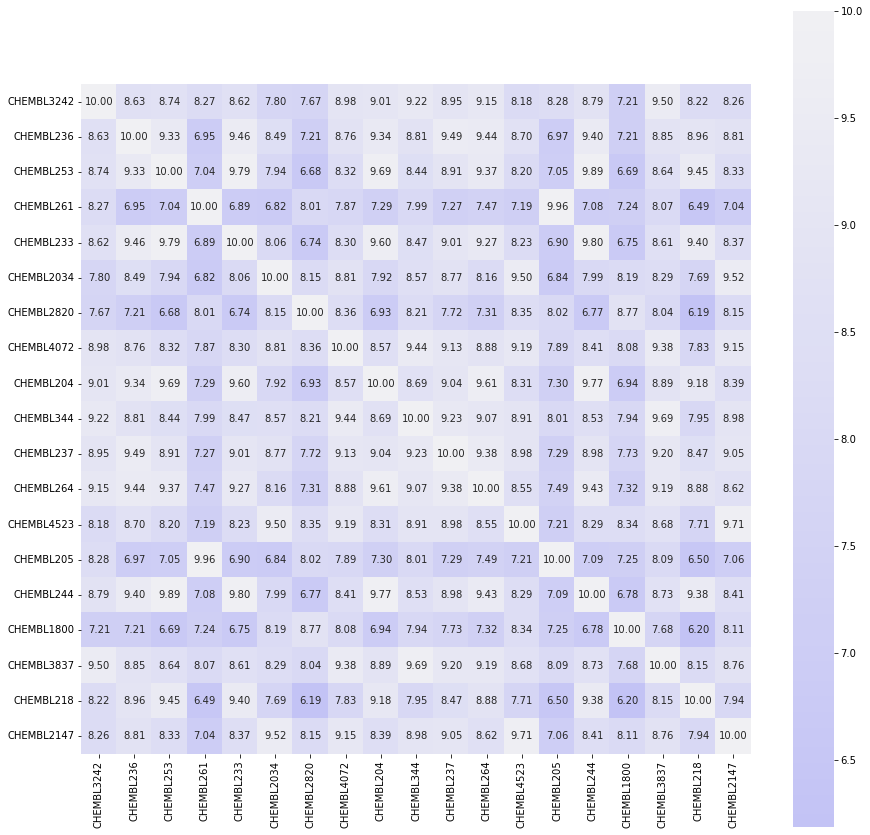

In [45]:
ax = heatmap(hi, outpath='./Score_axv/similarity_hist/heatmap_%s_hi.svg'%type)

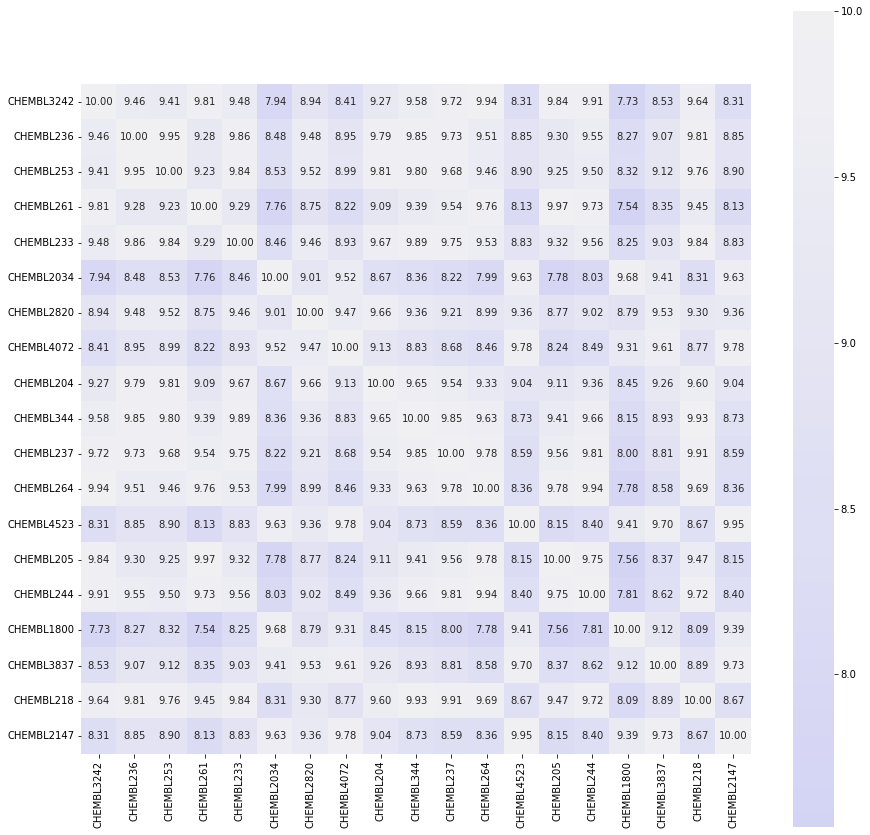

In [46]:
ax = heatmap(hi_c, outpath='./Score_axv/similarity_hist/heatmap_%s_hi_core.svg'%type)

In [47]:
val = hi.values
idx = [0, 9, 12]

for i in range(1, len(idx)):
    for j in range(1, len(idx)):
        ave = regional_average(val, idx[i-1], idx[i], idx[j-1], idx[j])
        print(round(ave, 2))

8.2
8.7
8.7
9.23


In [48]:
for i in range(1, len(idx)):
    for j in range(1, len(idx)):
        med = regional_median(val, idx[i-1], idx[i], idx[j-1], idx[j])
        print(round(med, 2))

8.29
8.88
8.88
9.23


In [49]:
val = hi_c.values
for i in range(1, len(idx)):
    for j in range(1, len(idx)):
        ave = regional_average(val, idx[i-1], idx[i], idx[j-1], idx[j])
        print(round(ave, 2))

9.15
9.32
9.32
9.75


In [50]:
for i in range(1, len(idx)):
    for j in range(1, len(idx)):
        med = regional_median(val, idx[i-1], idx[i], idx[j-1], idx[j])
        print(round(med, 2))

9.28
9.53
9.53
9.78


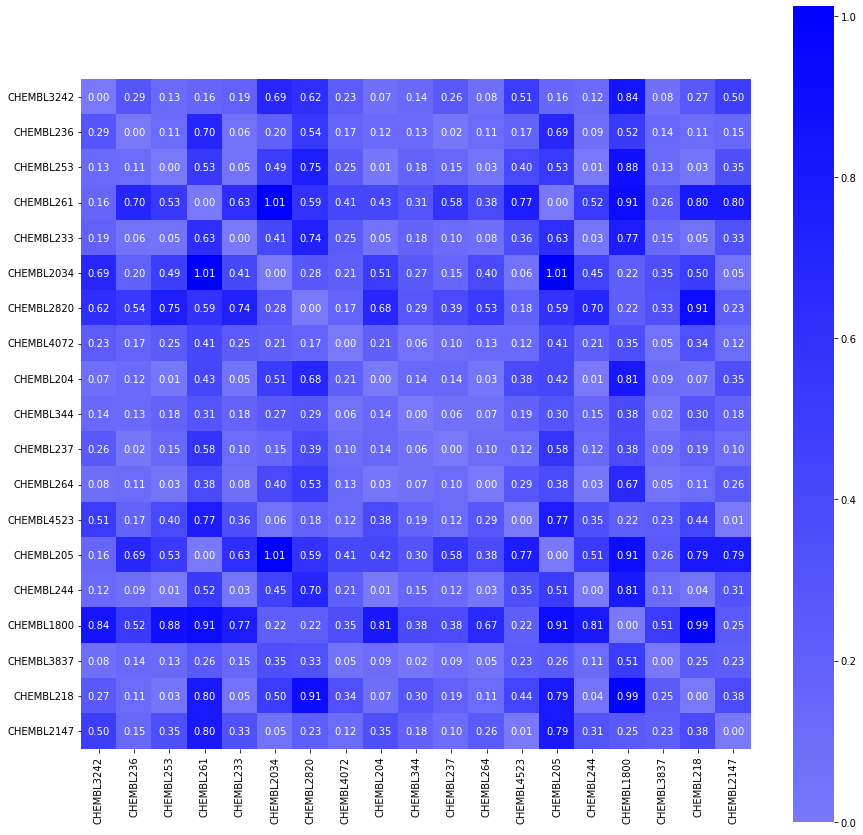

In [51]:
ax = heatmap(js, outpath='Score_axv/similarity_hist/heatmap_%s_js.svg'%type, cmap_rev=False)

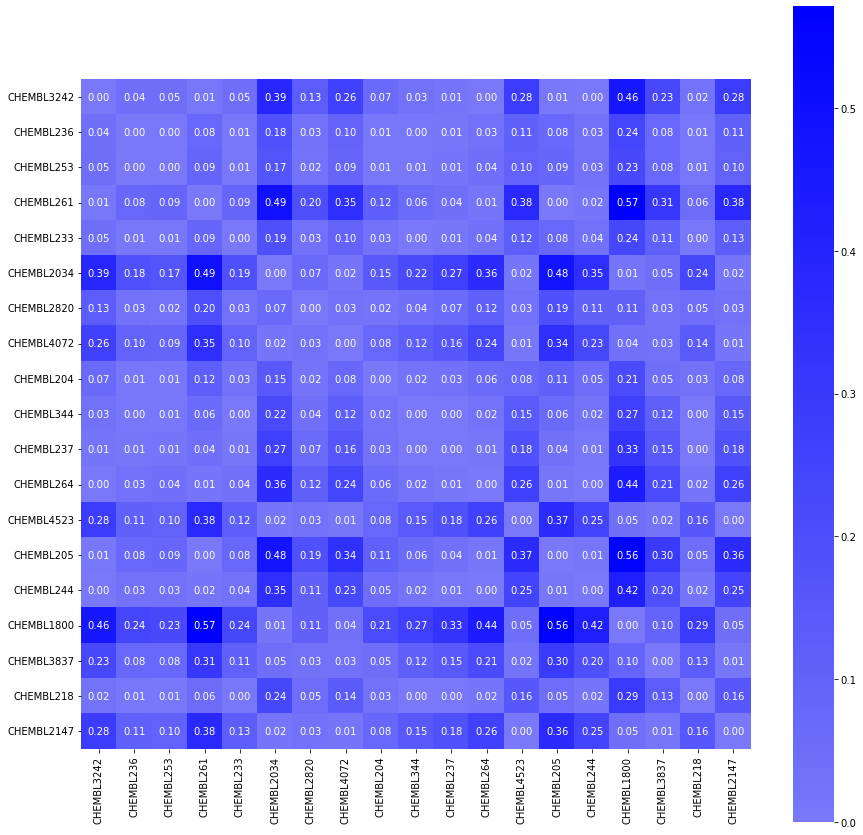

In [52]:
ax = heatmap(js_c, outpath='Score_axv/similarity_hist/heatmap_%s_js_core.svg'%type, cmap_rev=False)

In [53]:
val = js.values

for i in range(1, len(idx)):
    for j in range(1, len(idx)):
        ave = regional_average(val, idx[i-1], idx[i], idx[j-1], idx[j])
        print(round(ave, 2))

0.36
0.2
0.2
0.08


In [54]:
for i in range(1, len(idx)):
    for j in range(1, len(idx)):
        med = regional_median(val, idx[i-1], idx[i], idx[j-1], idx[j])
        print(round(med, 2))

0.26
0.14
0.14
0.07


In [55]:
val = js_c.values

for i in range(1, len(idx)):
    for j in range(1, len(idx)):
        ave = regional_average(val, idx[i-1], idx[i], idx[j-1], idx[j])
        print(round(ave, 2))

0.1
0.08
0.08
0.01


In [56]:
for i in range(1, len(idx)):
    for j in range(1, len(idx)):
        med = regional_median(val, idx[i-1], idx[i], idx[j-1], idx[j])
        print(round(med, 2))

0.08
0.04
0.04
0.01


# Target name

In [57]:
tlist = pd.read_csv('./Dataset/target_list.tsv', sep='\t', index_col='chembl_tid')

for tid in hi.keys():
    print(tid, ': ', tlist.loc[tid, 'primary_name'])

CHEMBL3242 :  Carbonic anhydrase 12
CHEMBL236 :  Delta-type opioid receptor
CHEMBL253 :  Cannabinoid receptor 2
CHEMBL261 :  Carbonic anhydrase 1
CHEMBL233 :  Mu-type opioid receptor
CHEMBL2034 :  Glucocorticoid receptor
CHEMBL2820 :  Coagulation factor XI
CHEMBL4072 :  Cathepsin B
CHEMBL204 :  Prothrombin
CHEMBL344 :  Melanin-concentrating hormone receptor 1
CHEMBL237 :  Kappa-type opioid receptor
CHEMBL264 :  Histamine H3 receptor
CHEMBL4523 :  Serine/threonine-protein kinase pim-2
CHEMBL205 :  Carbonic anhydrase 2
CHEMBL244 :  Coagulation factor X
CHEMBL1800 :  Corticotropin-releasing factor receptor 1
CHEMBL3837 :  Procathepsin L
CHEMBL218 :  Cannabinoid receptor 1
CHEMBL2147 :  Serine/threonine-protein kinase pim-1
